## Import des librairies nécessaires

In [8]:
# import des librairies 
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')
sns.color_palette("Paired")
sns.set_palette('muted')            

import re
import operator

import warnings
warnings.filterwarnings('ignore')

#test
# afficher seulement les minutes et secondes
import matplotlib.dates as md
from matplotlib.dates import MinuteLocator
ms_form = md.DateFormatter('%M:%S')

pd.set_option("display.max_columns", 500)

# from nba_api.stats.endpoints import playercareerstats
# from nba_api.stats.static import players as pls
# best20nba = ['LeBron James', 'Kevin Durant', 'Stephen Curry', 'James Harden', 'Klay Thompson', 'Chris Paul', 'Kawhi Leonard', 'Russell Westbrook', 
# 'Jimmy Butler', 'Jayson Tatum', 'Paul George', 'Nikola Jokic', 'Al Horford', 'Jaylen Brown', 'Giannis Antetokounmpo', 'Kyrie Irving',  'Kyle Lowry',  
# 'Draymond Green', 'Damian Lillard', 'Khris Middleton']

# récupération des ids des joueurs
# all_players = pls.get_players()
# best_20_ids = [(player['id'],player["full_name"]) for player in all_players if best20nba.__contains__(player["full_name"])]

## Aperçu de tous les fichiers

In [5]:
files = ['2000-01_pbp.csv','2001-02_pbp.csv','2002-03_pbp.csv','2003-04_pbp.csv','2004-05_pbp.csv',
         '2005-06_pbp.csv','2006-07_pbp.csv','2007-08_pbp.csv','2008-09_pbp.csv','2009-10_pbp.csv',
         '2010-11_pbp.csv','2011-12_pbp.csv','2012-13_pbp.csv','2013-14_pbp.csv','2014-15_pbp.csv',
         '2015-16_pbp.csv','2016-17_pbp.csv','2017-18_pbp.csv','2018-19_pbp.csv','2019-20_pbp.csv']

for file in files:
    pbp = pd.read_csv("../data/raw/"+file, index_col=0)
    print("\n", file)
    print(pbp.info())


 2000-01_pbp.csv
<class 'pandas.core.frame.DataFrame'>
Index: 537157 entries, 0 to 401
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   EVENTMSGACTIONTYPE         537157 non-null  int64  
 1   EVENTMSGTYPE               537157 non-null  int64  
 2   EVENTNUM                   537157 non-null  int64  
 3   GAME_ID                    537157 non-null  int64  
 4   HOMEDESCRIPTION            280199 non-null  object 
 5   NEUTRALDESCRIPTION         0 non-null       float64
 6   PCTIMESTRING               537157 non-null  object 
 7   PERIOD                     537157 non-null  int64  
 8   PERSON1TYPE                537156 non-null  float64
 9   PERSON2TYPE                537157 non-null  int64  
 10  PERSON3TYPE                537157 non-null  int64  
 11  PLAYER1_ID                 537157 non-null  int64  
 12  PLAYER1_NAME               487491 non-null  object 
 13  PLAYER1_TEAM_ABBREV

## Info de base : nombre de ligne, valeurs manquantes, types des colonnes

In [11]:
# Changer le nom du fichier pour analyser une saison (entre 2000 et 2019)
pbp = pd.read_csv("../data/raw/2000-01_pbp.csv", index_col=0)
pbp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 537157 entries, 0 to 401
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   EVENTMSGACTIONTYPE         537157 non-null  int64  
 1   EVENTMSGTYPE               537157 non-null  int64  
 2   EVENTNUM                   537157 non-null  int64  
 3   GAME_ID                    537157 non-null  int64  
 4   HOMEDESCRIPTION            280199 non-null  object 
 5   NEUTRALDESCRIPTION         0 non-null       float64
 6   PCTIMESTRING               537157 non-null  object 
 7   PERIOD                     537157 non-null  int64  
 8   PERSON1TYPE                537156 non-null  float64
 9   PERSON2TYPE                537157 non-null  int64  
 10  PERSON3TYPE                537157 non-null  int64  
 11  PLAYER1_ID                 537157 non-null  int64  
 12  PLAYER1_NAME               487491 non-null  object 
 13  PLAYER1_TEAM_ABBREVIATION  487491 non

## Taux de valeurs manquantes

In [5]:
# TAUX DE NA
pbp.isna().sum()/len(pbp)

EVENTMSGACTIONTYPE           0.000000
EVENTMSGTYPE                 0.000000
EVENTNUM                     0.000000
GAME_ID                      0.000000
HOMEDESCRIPTION              0.478367
NEUTRALDESCRIPTION           1.000000
PCTIMESTRING                 0.000000
PERIOD                       0.000000
PERSON1TYPE                  0.000002
PERSON2TYPE                  0.000000
PERSON3TYPE                  0.000000
PLAYER1_ID                   0.000000
PLAYER1_NAME                 0.092461
PLAYER1_TEAM_ABBREVIATION    0.092461
PLAYER1_TEAM_CITY            0.092461
PLAYER1_TEAM_ID              0.092461
PLAYER1_TEAM_NICKNAME        0.092461
PLAYER2_ID                   0.000000
PLAYER2_NAME                 0.784540
PLAYER2_TEAM_ABBREVIATION    0.784540
PLAYER2_TEAM_CITY            0.784540
PLAYER2_TEAM_ID              0.784540
PLAYER2_TEAM_NICKNAME        0.784540
PLAYER3_ID                   0.000000
PLAYER3_NAME                 0.972989
PLAYER3_TEAM_ABBREVIATION    0.972989
PLAYER3_TEAM

In [6]:
# Taux 0 sur PLAYER ID
print('PLAYER1_ID: %.2f%%' % (len(pbp[pbp.PLAYER1_ID==0])/len(pbp)*100))
print('PLAYER2_ID: %.2f%%' % (len(pbp[pbp.PLAYER2_ID==0])/len(pbp)*100))
print('PLAYER3_ID: %.2f%%' % (len(pbp[pbp.PLAYER3_ID==0])/len(pbp)*100))

PLAYER1_ID: 2.23%
PLAYER2_ID: 78.45%
PLAYER3_ID: 97.28%


## Analyse de EventMsgType

In [7]:
# distribution des valeurs
pbp.EVENTMSGTYPE.value_counts(normalize=True)

EVENTMSGTYPE
4     0.226625
2     0.198823
1     0.157989
3     0.110094
6     0.102640
8     0.080120
5     0.066619
9     0.029442
13    0.009044
12    0.009033
7     0.005404
10    0.003923
11    0.000244
Name: proportion, dtype: float64

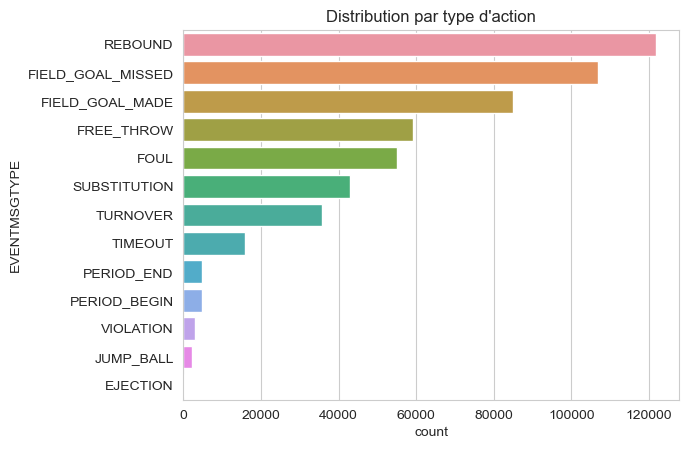

In [10]:
eventmsgtypes = {
    1: "FIELD_GOAL_MADE",
    2 : "FIELD_GOAL_MISSED",
    3 : "FREE_THROW",
    4 : "REBOUND",
    5 : "TURNOVER",
    6 : "FOUL",
    7 : "VIOLATION",
    8 : "SUBSTITUTION",
    9 : "TIMEOUT",
    10 : "JUMP_BALL",
    11 : "EJECTION" ,
    12 : "PERIOD_BEGIN" ,
    13 : "PERIOD_END" 
}

data = pbp.copy()
data.EVENTMSGTYPE = data.EVENTMSGTYPE.replace(eventmsgtypes)
sns.countplot(data=data, y='EVENTMSGTYPE', order=data['EVENTMSGTYPE'].value_counts().index)
plt.title("Distribution par type d'action")
plt.show()

## Analyse de EventMsgActionTypes

In [14]:
# distribution des valeurs
pbp.EVENTMSGACTIONTYPE.value_counts(normalize=True)

EVENTMSGACTIONTYPE
1     0.335503
0     0.314696
2     0.065901
5     0.059845
11    0.052824
12    0.048047
4     0.024306
3     0.018903
42    0.017941
10    0.008921
46    0.008666
7     0.007690
8     0.006903
47    0.005276
16    0.003865
44    0.003103
49    0.001715
17    0.001648
6     0.001307
41    0.001281
40    0.001244
52    0.001229
45    0.000977
58    0.000875
56    0.000828
14    0.000646
15    0.000612
59    0.000598
13    0.000594
21    0.000547
61    0.000490
43    0.000458
53    0.000419
19    0.000372
18    0.000343
51    0.000294
9     0.000285
50    0.000268
57    0.000195
55    0.000141
48    0.000104
60    0.000074
20    0.000028
62    0.000015
54    0.000013
22    0.000009
Name: proportion, dtype: float64

In [ ]:
# Extraction des valeurs possibles de EVENTMSGACTIONTYPE quand EventMsgType 1
p = re.compile(r'(\s{2}|\' )([\w+ ]*)')

description = ''
event_msg_action_types = {}

#loop over the play by play data
for index, play in pbp[pbp.EVENTMSGTYPE==1].iterrows():
    description = play['HOMEDESCRIPTION'] if play['HOMEDESCRIPTION'] is not None else play['VISITORDESCRIPTION']
    if description is not None and description is not np.nan:
        #do a bit of searching(regex) and a little character magic: underscores and upper case
        event_msg_action = re.sub(' ', '_', p.search(description).groups()[1].rstrip()).upper()
        #Add it to our dictionary
        event_msg_action_types[event_msg_action] = play['EVENTMSGACTIONTYPE']
        
#sort it all
event_msg_action_types = sorted(event_msg_action_types.items(), key=operator.itemgetter(0))

#output a class that we could plug into our code base
for action in event_msg_action_types:
    print(f'\t{action[0]} = {action[1]}')

In [15]:
# Extraction des valeurs possibles de EVENTMSGACTIONTYPE quand EventMsgType 2
p = re.compile(r'(\s{2}|\' )([\w+ ]*)')

#declare a few variables
description = ''
event_msg_action_types = {}

#loop over the play by play data
#do a bit of findall(regex) and a little character magic: underscores and upper case
#we're using a findall here as we have to deal with the extra word MISS at the beginning of the text.
#that extra text means we'll have multiple matches for our regex.
for index, play in pbp[pbp.EVENTMSGTYPE==2].iterrows():
    match = list()
    if play['HOMEDESCRIPTION'] is not None and play['HOMEDESCRIPTION'] is not np.nan: 
        match = p.findall(play['HOMEDESCRIPTION'])
    
    if not match:
        match = p.findall(play['VISITORDESCRIPTION'])

    event_msg_action = re.sub(' ', '_', match[0][1]).upper()
    event_msg_action_types[event_msg_action] = play['EVENTMSGACTIONTYPE']
        
event_msg_action_types = sorted(event_msg_action_types.items(), key=operator.itemgetter(0))

for action in event_msg_action_types:
    print(f'\t{action[0]} = {action[1]}')

	3PT_HOOK_SHOT = 3
	3PT_JUMP_SHOT = 1
	3PT_LAYUP = 40
	3PT_RUNNING_JUMP_SHOT = 46
	3PT_TURNAROUND_JUMP_SHOT = 47
	ALLEY_OOP_DUNK = 52
	ALLEY_OOP_LAYUP = 43
	DRIVING_DUNK = 49
	DRIVING_FINGER_ROLL = 61
	DRIVING_HOOK_SHOT = 57
	DRIVING_LAYUP = 42
	DUNK = 7
	FINGER_ROLL = 59
	HOOK_SHOT = 3
	JUMP_SHOT = 1
	LAYUP = 40
	NO_SHOT = 0
	REVERSE_DUNK = 51
	REVERSE_LAYUP = 44
	RUNNING_DUNK = 50
	RUNNING_FINGER_ROLL = 60
	RUNNING_HOOK_SHOT = 56
	RUNNING_JUMP_SHOT = 46
	RUNNING_LAYUP = 41
	RUNNING_TIP_SHOT = 54
	SLAM_DUNK = 8
	TIP_SHOT = 4
	TURNAROUND_FINGER_ROLL = 62
	TURNAROUND_HOOK_SHOT = 58
	TURNAROUND_JUMP_SHOT = 47


## Analyse de PCTimeString

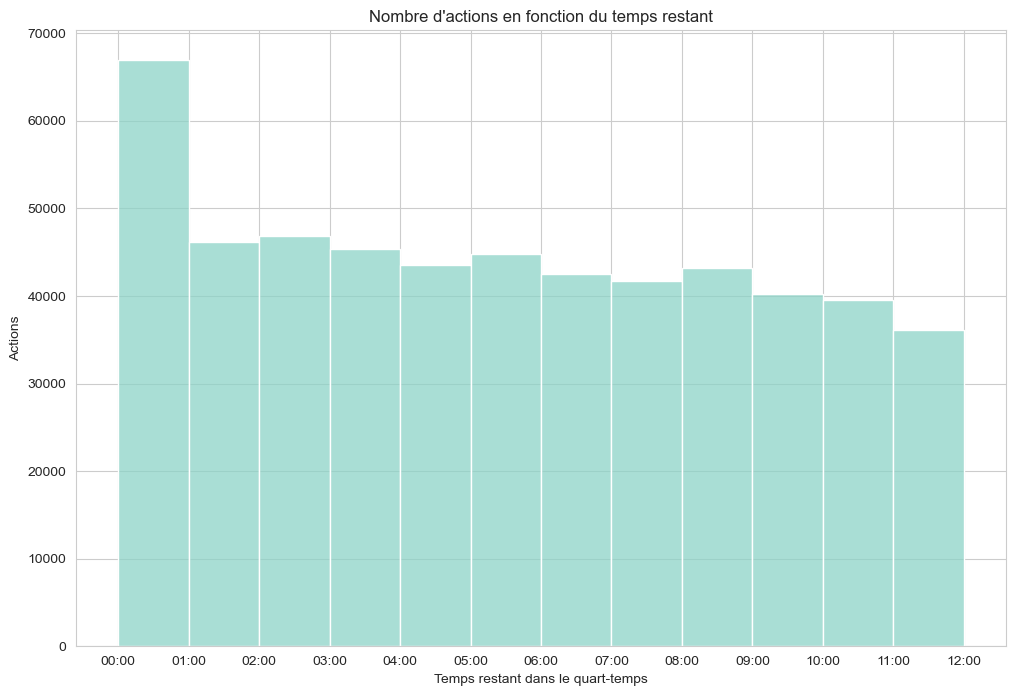

In [48]:
# changement du champ PCTIMESTRING en datetime
pbp.PCTIMESTRING = pd.to_datetime(pbp.PCTIMESTRING, format="%M:%S")

# plot distribution 
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data = pbp, x='PCTIMESTRING', bins=12, ax=ax)
ax.xaxis.set_major_formatter(ms_form)
ax.set_title("Nombre d'actions en fonction du temps restant")
ax.xaxis.set_major_locator(MinuteLocator(interval=1))
ax.set_ylabel("Actions")
ax.set_xlabel("Temps restant dans le quart-temps")
fig.show()

## Analyse de PersonType

In [49]:
# distribution des valeurs
print(pbp.PERSON1TYPE.value_counts(normalize=True), end='\n\n')
print(pbp.PERSON2TYPE.value_counts(normalize=True), end='\n\n')
print(pbp.PERSON3TYPE.value_counts(normalize=True), end='\n\n')

# 0 = valeurs manquantes

PERSON1TYPE
4.0    0.457165
5.0    0.450376
3.0    0.034897
2.0    0.034711
0.0    0.018077
1.0    0.004211
7.0    0.000313
6.0    0.000251
Name: proportion, dtype: float64

PERSON2TYPE
0    0.784536
5    0.108184
4    0.107276
7    0.000004
Name: proportion, dtype: float64

PERSON3TYPE
0    0.854398
1    0.118399
4    0.014506
5    0.012505
3    0.000099
2    0.000093
Name: proportion, dtype: float64



In [50]:
# PERSON1TYPE est égal à 0 lorsqu'il s'agit d'un début ou une fin de quartemps 
pbp[pbp.PERSON1TYPE==0].EVENTMSGTYPE.unique()

array([12, 13], dtype=int64)

In [53]:
# la variable person1type ne correspond pas à la posistion du joueur
pbpplayers = pbp[['PERSON1TYPE', 'PLAYER1_ID',	'PLAYER1_NAME']].drop_duplicates(subset='PLAYER1_NAME').dropna()
players = pd.read_csv("../data/raw/player_data.csv", index_col=0)
pbpWithPlayers = pbpplayers.join(players, on=['PLAYER1_NAME']).sort_values(by='PERSON1TYPE')[['PLAYER1_NAME', 'PERSON1TYPE', 'position']]
pbpWithPlayers.head(5)

,PLAYER1_NAME,PERSON1TYPE,position
1,Brian Grant,4.0,F
123,Doug Overton,4.0,G
90,Chris Carr,4.0,G
134,Felipe Lopez,4.0,G
118,Dean Garrett,4.0,C


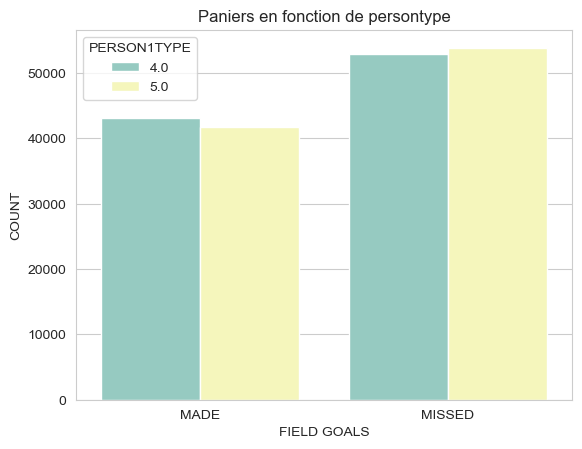

In [54]:
pbp_shoots = pbp[pbp.EVENTMSGTYPE < 3] # on filtre sur les shoots seulement
sns.countplot(data=pbp_shoots, x="EVENTMSGTYPE", hue="PERSON1TYPE")
plt.title("Paniers en fonction de persontype")
plt.xticks([0,1], labels=['MADE', 'MISSED'])
plt.xlabel("FIELD GOALS")
plt.ylabel("COUNT")
plt.show()

## Analyse de Player1_ID

In [55]:
# valeurs manquantes 
print('Valeurs manquantes:', pbp.PLAYER1_ID.isna().sum())

# ID = 0
print(pbp[pbp.PLAYER1_ID == 0].EVENTMSGTYPE.value_counts())

print("\nLes valeurs = 0 correspondent aux début/fin de période et timeout demandés par les équipes.")


Valeurs manquantes: 0
EVENTMSGTYPE
13    4858
12    4852
9     2262
8        1
Name: count, dtype: int64

Les valeurs = 0 correspondent aux début/fin de période et timeout demandés par les équipes.


## Analyse de Player2_ID

In [56]:
# valeurs manquantes 
print('Valeurs manquantes:', pbp.PLAYER2_ID.isna().sum())

# ID = 0 
print(len(pbp[pbp.PLAYER2_ID == 0]))

# présence du player 2 en cas de tir
x = pbp[(pbp.PLAYER2_ID != 0) & (pbp.EVENTMSGTYPE<3)][['EVENTMSGACTIONTYPE','EVENTMSGTYPE', 'HOMEDESCRIPTION', 'VISITORDESCRIPTION']]

print('Valeurs prises par EVENTMSGTYPE lorsque PLAYER2_ID est indiqué:', x.EVENTMSGTYPE.unique())
print("Le champ player2 ID n'est rempli qu'en cas de panier marqué (passe décisive)")

Valeurs manquantes: 0
421419
Valeurs prises par EVENTMSGTYPE lorsque PLAYER2_ID est indiqué: [1]
Le champ player2 ID n'est rempli qu'en cas de panier marqué (passe décisive)


## Analyse de Player3_ID

In [57]:
# valeurs manquantes 
print('Valeurs manquantes:', pbp.PLAYER3_ID.isna().sum())

# ID = 0 
print(len(pbp[pbp.PLAYER3_ID == 0]))

# présence du player 2 en cas de tir
x = pbp[(pbp.PLAYER3_ID != 0) & (pbp.EVENTMSGTYPE<3)][['EVENTMSGACTIONTYPE','EVENTMSGTYPE', 'HOMEDESCRIPTION', 'VISITORDESCRIPTION']]

print('Valeurs prises par EVENTMSGTYPE lorsque PLAYER3_ID est indiqué:', x.EVENTMSGTYPE.unique())
print("Le champ PLAYER3_ID n'est rempli qu'en cas de panier raté (block)")

display(x.head())

Valeurs manquantes: 0
522545
Valeurs prises par EVENTMSGTYPE lorsque PLAYER3_ID est indiqué: [2]
Le champ PLAYER3_ID n'est rempli qu'en cas de panier raté (block)


,EVENTMSGACTIONTYPE,EVENTMSGTYPE,HOMEDESCRIPTION,VISITORDESCRIPTION
70,1,2,Bowen BLOCK (1 BLK),MISS Iverson 12' Jump Shot
96,42,2,Mourning BLOCK (1 BLK),MISS McKie Driving Layup
225,5,2,Majerle BLOCK (1 BLK),MISS Hill Layup
403,40,2,MISS Bowen Layup,Mutombo BLOCK (1 BLK)
406,1,2,Mourning BLOCK (2 BLK),MISS Iverson 6' Jump Shot


## Analyse de Score

In [58]:
# valeurs manquantes 
print('Valeurs manquantes:', pbp.SCORE.isna().sum())

# présence du score en cas de tir
x = pbp[(pbp.SCORE.notna()) & (pbp.EVENTMSGTYPE<3)][['EVENTMSGACTIONTYPE','EVENTMSGTYPE', 'HOMEDESCRIPTION', 'VISITORDESCRIPTION', 'SCORE', 'SCOREMARGIN']]

# 
print('Valeurs prises par EVENTMSGTYPE lorsque SCORE est indiqué:', x.EVENTMSGTYPE.unique())
print("Le champ SCORE n'est rempli qu'en cas de panier réussi.")

display(x.head())

Valeurs manquantes: 399567
Valeurs prises par EVENTMSGTYPE lorsque SCORE est indiqué: [1]
Le champ SCORE n'est rempli qu'en cas de panier réussi.


,EVENTMSGACTIONTYPE,EVENTMSGTYPE,HOMEDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN
2,1,1,NaN,Iverson 21' Jump Shot (2 PTS),2 - 0,-2
4,1,1,Mason 17' Jump Shot (2 PTS),NaN,2 - 2,TIE
9,5,1,NaN,Lynch Layup (2 PTS) (Snow 1 AST),4 - 2,-2
19,42,1,NaN,Iverson Driving Layup (4 PTS),6 - 2,-4
23,1,1,NaN,Iverson 24' 3PT Jump Shot (7 PTS) (Mutombo 1 AST),9 - 2,-7


## Analyse de Score Margin

In [59]:
# valeurs manquantes 
print('Valeurs manquantes:', pbp.SCOREMARGIN.isna().sum())

# présence du score en cas de tir
x = pbp[(pbp.SCOREMARGIN.notna()) & (pbp.EVENTMSGTYPE<4)][['EVENTMSGACTIONTYPE','EVENTMSGTYPE', 'HOMEDESCRIPTION', 'VISITORDESCRIPTION', 'SCORE', 'SCOREMARGIN']]

# 
print('Valeurs prises par EVENTMSGTYPE lorsque SCORE est indiqué:', x.EVENTMSGTYPE.unique())
print("Le champ SCOREMARGIN n'est rempli qu'en cas de panier réussi.")

display(x.head())

Valeurs manquantes: 399567
Valeurs prises par EVENTMSGTYPE lorsque SCORE est indiqué: [1 3]
Le champ SCOREMARGIN n'est rempli qu'en cas de panier réussi.


,EVENTMSGACTIONTYPE,EVENTMSGTYPE,HOMEDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN
2,1,1,NaN,Iverson 21' Jump Shot (2 PTS),2 - 0,-2
4,1,1,Mason 17' Jump Shot (2 PTS),NaN,2 - 2,TIE
9,5,1,NaN,Lynch Layup (2 PTS) (Snow 1 AST),4 - 2,-2
19,42,1,NaN,Iverson Driving Layup (4 PTS),6 - 2,-4
23,1,1,NaN,Iverson 24' 3PT Jump Shot (7 PTS) (Mutombo 1 AST),9 - 2,-7


# Analyse multivariée

#### Filtrage du dataset sur les 20 plus gros marqueurs de l'année, en ne prenant que les évènements de type  FIELD_GOAL_MADE et FIELD_GOAL_MISSED


In [93]:
# lister les 20 meilleurs tireurs
best_20_scorers = pbp[pbp.EVENTMSGTYPE==1][['PLAYER1_ID', 'PLAYER1_NAME']].value_counts()[:20]

# filtrer le dataset
ids = best_20_scorers.index.get_level_values('PLAYER1_ID')
filtered_df = pbp[(pbp.PLAYER1_ID.isin(ids)) & (pbp.EVENTMSGTYPE<3)].reset_index()

# permet de passer de 500k+ à 30k lignes

# suppression des colonnes inutiles
filtered_df = filtered_df.drop(['NEUTRALDESCRIPTION', 'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION', 'PLAYER2_TEAM_CITY', 'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_NICKNAME', 'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION', 'PLAYER3_TEAM_CITY', 'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME', 'PERSON2TYPE', 'PERSON3TYPE'], axis = 1)
filtered_df.PLAYER1_TEAM_ID = filtered_df.PLAYER1_TEAM_ID.astype(int)

# ajout de la variable shot distance, calculée à partir de HOMEDESCRIPTION et VISITORDESCRIPTION
filtered_df['SHOTDISTANCE'] = '0'
#trouve les distances de 0 à 99 pieds
p = re.compile("[0-9][0-9]'|[0-9]'")

for index, play in filtered_df.iterrows():
    match = list()
    if play['HOMEDESCRIPTION'] is not None and play['HOMEDESCRIPTION'] is not np.nan: 
        match = p.findall(play['HOMEDESCRIPTION'])
    
    if play['VISITORDESCRIPTION'] is not None and play['VISITORDESCRIPTION'] is not np.nan: 
        match = p.findall(play['VISITORDESCRIPTION'])
    
    if(len(match) > 0):
        filtered_df.loc[index, 'SHOTDISTANCE'] = match[0].replace("'", "")

filtered_df['SHOTDISTANCE'] = filtered_df['SHOTDISTANCE'].astype(int)

## Tirs des 20 meilleurs marqueurs de la saison

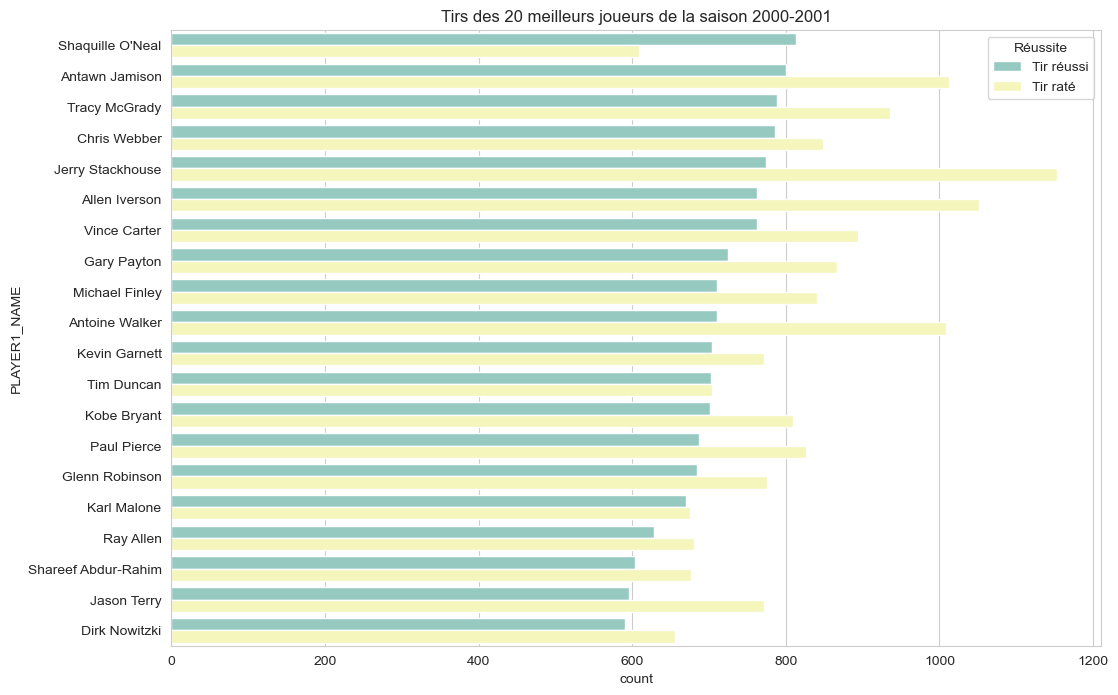

In [73]:
plt.figure(figsize=(12,8))
plot = sns.countplot(data=filtered_df, 
              y="PLAYER1_NAME", 
              hue="EVENTMSGTYPE", 
              order=filtered_df[filtered_df.EVENTMSGTYPE==1]['PLAYER1_NAME'].value_counts().index)
plt.title('Tirs des 20 meilleurs joueurs de la saison 2000-2001')

# Légende 
leg = plot.axes.get_legend()
leg.set_title('Réussite')
new_labels = ['Tir réussi', 'Tir raté']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)


## Tirs en fonction de leur types

In [76]:
eventnames= {
    102:'3PT DRIVING FLOATING BANK JUMP SHOT',
    101:'3PT DRIVING FLOATING JUMP SHOT',
    63:'3PT FADEAWAY JUMPER',
    78:'3PT FLOATING JUMP SHOT',
    66:'3PT JUMP BANK SHOT',
    1:'3PT JUMP SHOT',
    79:'3PT PULLUP JUMP SHOT',
    2:'3PT RUNNING JUMP SHOT',
    103:'3PT RUNNING PULL',
    104:'3PT STEP BACK BANK JUMP SHOT',
    80:'3PT STEP BACK JUMP SHOT',
    86:'3PT TURNAROUND FADEAWAY',
    105:'3PT TURNAROUND FADEAWAY BANK JUMP SHOT',
    47:'3PT TURNAROUND JUMP SHOT',
    52:'ALLEY OOP DUNK',
    43:'ALLEY OOP LAYUP',
    108:'CUTTING DUNK SHOT',
    99:'CUTTING FINGER ROLL LAYUP SHOT',
    98:'CUTTING LAYUP SHOT',
    93:'DRIVING BANK HOOK SHOT',
    9:'DRIVING DUNK',
    75:'DRIVING FINGER ROLL LAYUP',
    102:'DRIVING FLOATING BANK JUMP SHOT',
    101:'DRIVING FLOATING JUMP SHOT',
    57:'DRIVING HOOK SHOT',
    6:'DRIVING LAYUP',
    109:'DRIVING REVERSE DUNK SHOT',
    73:'DRIVING REVERSE LAYUP',
    7:'DUNK',
    63:'FADEAWAY JUMPER',
    71:'FINGER ROLL LAYUP',
    78:'FLOATING JUMP SHOT',
    67:'HOOK BANK SHOT',
    3:'HOOK SHOT',
    66:'JUMP BANK SHOT',
    1:'JUMP SHOT',
    5:'LAYUP',
    79:'PULLUP JUMP SHOT',
    87:'PUTBACK DUNK',
    72:'PUTBACK LAYUP',
    51:'REVERSE DUNK',
    44:'REVERSE LAYUP',
    106:'RUNNING ALLEY OOP DUNK SHOT',
    100:'RUNNING ALLEY OOP LAYUP SHOT',
    50:'RUNNING DUNK',
    76:'RUNNING FINGER ROLL LAYUP',
    2:'RUNNING JUMP SHOT',
    41:'RUNNING LAYUP',
    103:'RUNNING PULL',
    110:'RUNNING REVERSE DUNK SHOT',
    74:'RUNNING REVERSE LAYUP',
    104:'STEP BACK BANK JUMP SHOT',
    80:'STEP BACK JUMP SHOT',
    107:'TIP DUNK SHOT',
    97:'TIP LAYUP SHOT',
    96:'TURNAROUND BANK HOOK SHOT',
    86:'TURNAROUND FADEAWAY',
    105:'TURNAROUND FADEAWAY BANK JUMP SHOT',
    58:'TURNAROUND HOOK SHOT',
    47:'TURNAROUND JUMP SHOT',
    42:'LAYUP',
	49:'DRIVING_DUNK',
	46:'RUNNING_JUMP_SHOT',
	8:'SLAM_DUNK',
	4:'TIP_SHOT'
}

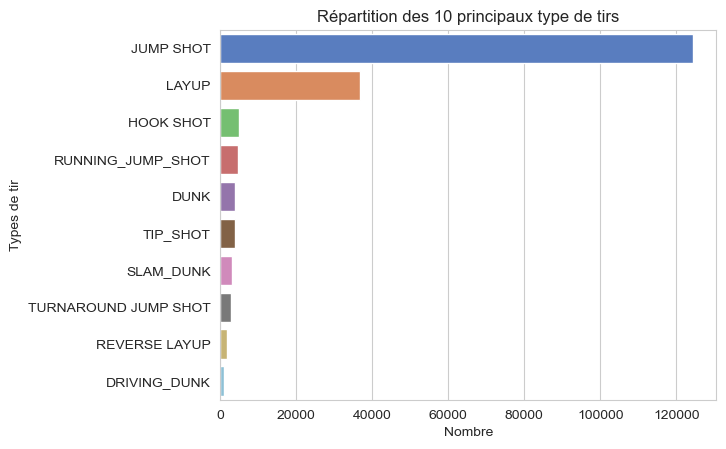

In [85]:
data = filtered_df.copy()
data.EVENTMSGACTIONTYPE = data.EVENTMSGACTIONTYPE.replace(eventnames)
values = data.EVENTMSGACTIONTYPE.value_counts()[:10].index
data = data[data.EVENTMSGACTIONTYPE.isin(values)]

sns.countplot(data=data, 
              y="EVENTMSGACTIONTYPE", 
              order=data['EVENTMSGACTIONTYPE'].value_counts().index)

plt.title('Répartition des 10 principaux type de tirs')
plt.ylabel("Types de tir")
plt.xlabel("Nombre")
plt.show()

### Réussite des tirs en fonction du quartemps

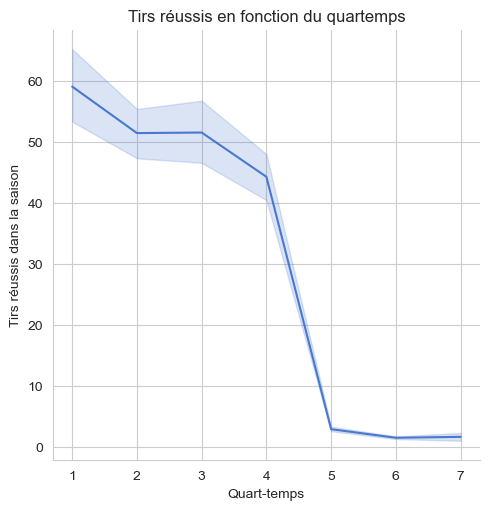

In [86]:
# shoots réussis par joueurs et par quartemps
reussis = filtered_df[filtered_df.EVENTMSGTYPE==1].groupby(['PLAYER1_NAME','PERIOD']).agg('count')
rate = filtered_df[filtered_df.EVENTMSGTYPE==2].groupby(['PLAYER1_NAME','PERIOD']).agg('count')
sns.relplot(reussis, x='PERIOD', y='EVENTMSGACTIONTYPE', kind='line')
plt.title("Tirs réussis en fonction du quartemps")
plt.xlabel("Quart-temps")
plt.ylabel("Tirs réussis dans la saison")
plt.show()

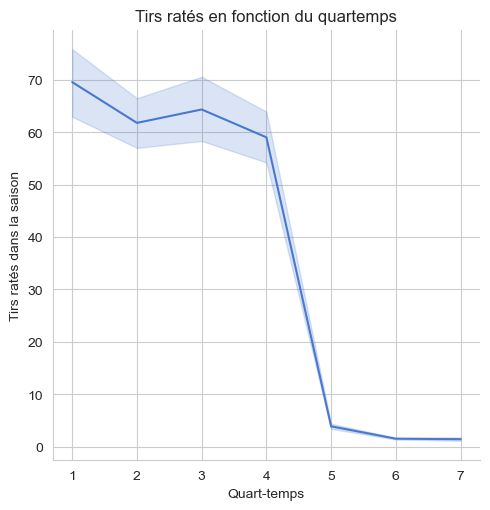

In [87]:
# shoots réussis par joueurs et par quartemps
rate = filtered_df[filtered_df.EVENTMSGTYPE==2].groupby(['PLAYER1_NAME','PERIOD']).agg('count')
sns.relplot(rate, x='PERIOD', y='EVENTMSGACTIONTYPE', kind='line')
plt.title("Tirs ratés en fonction du quartemps")
plt.xlabel("Quart-temps")
plt.ylabel("Tirs ratés dans la saison")
plt.show()

## Tirs vs. Quart-temps

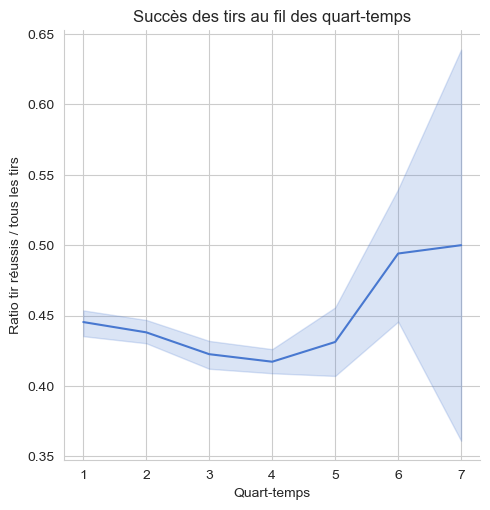

In [88]:
reussis = filtered_df[filtered_df.EVENTMSGTYPE==1].groupby(['PLAYER1_NAME','PERIOD'])['EVENTMSGACTIONTYPE'].agg('count')
rates = filtered_df[filtered_df.EVENTMSGTYPE==2].groupby(['PLAYER1_NAME','PERIOD'])['EVENTMSGACTIONTYPE'].agg('count')
moyenne = filtered_df[filtered_df.EVENTMSGTYPE==1].groupby(['PLAYER1_NAME','PERIOD']).agg('count')
moyenne['RATIO']= reussis / (rates+reussis)


sns.relplot(moyenne, x='PERIOD', y='RATIO', kind='line')
plt.title("Succès des tirs au fil des quart-temps")
plt.xlabel("Quart-temps")
plt.ylabel("Ratio tir réussis / tous les tirs")
plt.show()

## Tirs vs. Temps restant

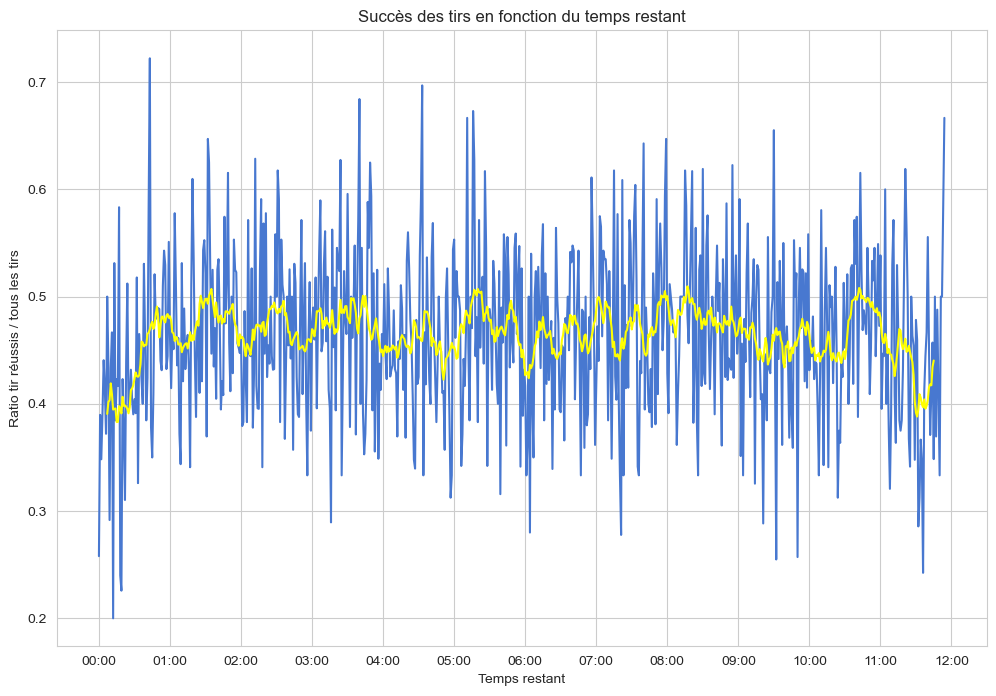

In [96]:
reussis = filtered_df[filtered_df.EVENTMSGTYPE==1].groupby(['PCTIMESTRING'])['EVENTMSGACTIONTYPE'].agg('count')
rates = filtered_df[filtered_df.EVENTMSGTYPE==2].groupby(['PCTIMESTRING'])['EVENTMSGACTIONTYPE'].agg('count')

moyenne = filtered_df[filtered_df.EVENTMSGTYPE<3].groupby(['PCTIMESTRING']).agg('count')
moyenne['RATIO']= reussis / (rates+reussis)

# 
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(moyenne, x='PCTIMESTRING', y='RATIO', ax=ax)
plt.title("Succès des tirs en fonction du temps restant")
plt.xlabel("Temps restant")
plt.ylabel("Ratio tir réussis / tous les tirs")

# moyenne mobile
mean = moyenne['RATIO'].rolling(window=15, center=True).mean()
plt.plot(mean, color="yellow")

ax.xaxis.set_major_formatter(ms_form)
ax.xaxis.set_major_locator(MinuteLocator(interval=1))

plt.show()

## Tirs vs PersonType

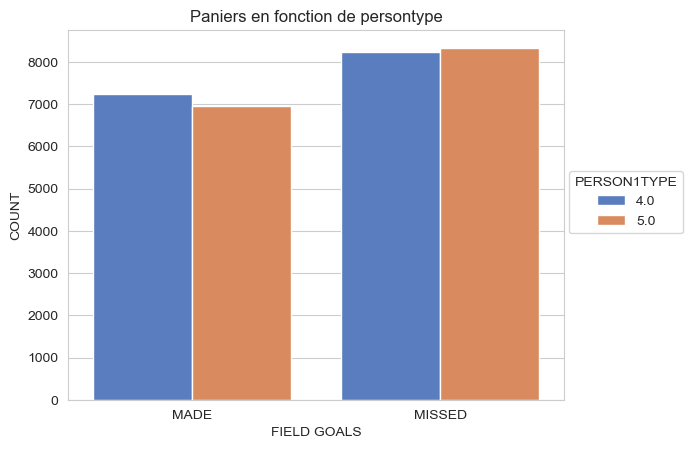

In [97]:
plot = sns.countplot(data=filtered_df, x="EVENTMSGTYPE", hue="PERSON1TYPE")
plt.title("Paniers en fonction de persontype")
plt.xticks([0,1], labels=['MADE', 'MISSED'])
plt.xlabel("FIELD GOALS")
plt.ylabel("COUNT")
# Légende 
leg = plot.axes.get_legend()
leg.set_title('PERSON1TYPE')
leg.set_loc((1.01,.45))
plt.show()


## Tirs vs Equipes

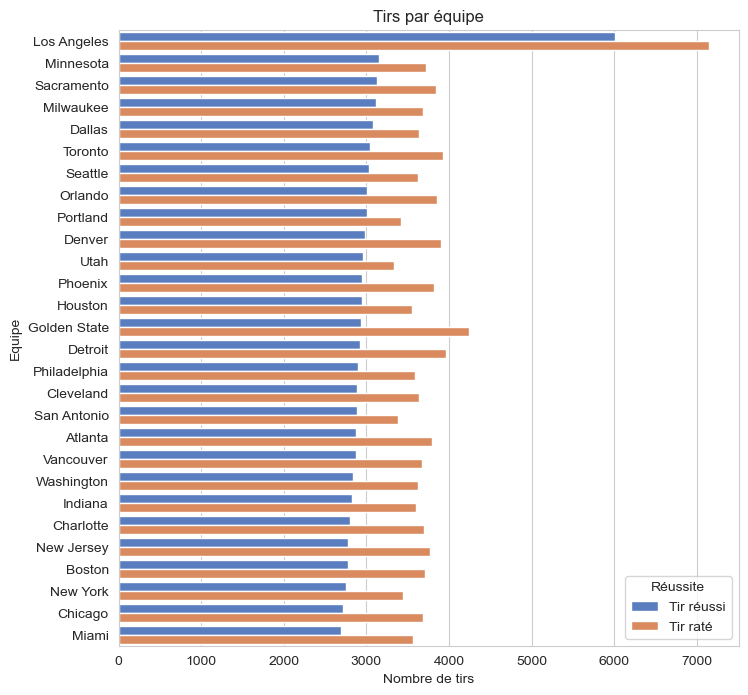

In [98]:
plt.figure(figsize=(8,8))
plot = sns.countplot(data=pbp[pbp.EVENTMSGTYPE<3], 
              y="PLAYER1_TEAM_CITY", 
              hue="EVENTMSGTYPE", 
              order=pbp[pbp.EVENTMSGTYPE==1]['PLAYER1_TEAM_CITY'].value_counts().index)
plt.title('Tirs par équipe')
plt.ylabel('Equipe')
plt.xlabel('Nombre de tirs')

# Légende 
leg = plot.axes.get_legend()
leg.set_title('Réussite')
new_labels = ['Tir réussi', 'Tir raté']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

### Tirs vs Distance

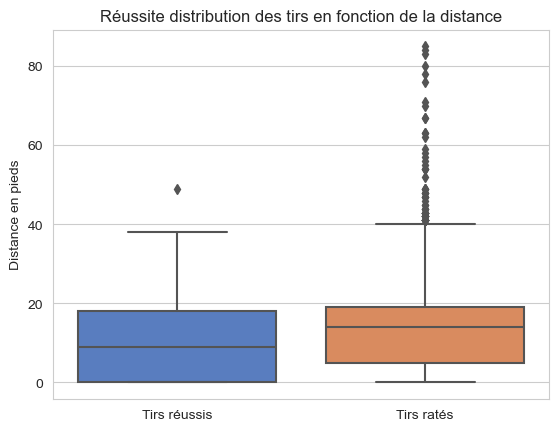

In [99]:
sns.boxplot(data = filtered_df, x = 'EVENTMSGTYPE', y='SHOTDISTANCE')
plt.xticks([0, 1], labels=['Tirs réussis', 'Tirs ratés'])
plt.ylabel("Distance en pieds")
plt.xlabel('')
plt.title("Réussite distribution des tirs en fonction de la distance")
plt.show()

# Analyse des tirs en fonction de l'action précédente

In [79]:
df = pd.read_csv("../data/raw/2000-01_pbp.csv", index_col=0)
df = df.set_index(['GAME_ID', 'EVENTNUM']).sort_index()

In [80]:
# previous action is an offensive rebound
df.loc[(df['EVENTMSGTYPE'] < 4) & 
       (df['PLAYER1_TEAM_ID'] == df['PLAYER1_TEAM_ID'].shift(1))  & 
       (df['PLAYER1_TEAM_ID'].shift(1) == df['PLAYER1_TEAM_ID'].shift(2)) & 
       (~df['EVENTMSGTYPE'].shift(1).isin([6,8,10])), 'PREVIOUS_OFF_REBOUND'] = True 
       
df['PREVIOUS_OFF_REBOUND'] = df['PREVIOUS_OFF_REBOUND'].fillna(False)

# previous action is a defensive rebound
df.loc[(df['EVENTMSGTYPE'] < 4) & 
       (df['PLAYER1_TEAM_ID'] == df['PLAYER1_TEAM_ID'].shift(1))  & 
       (df['PLAYER1_TEAM_ID'].shift(1) != df['PLAYER1_TEAM_ID'].shift(2)) & 
       (df['EVENTMSGTYPE'].shift(1) == 4), 'PREVIOUS_DEF_REBOUND'] = True

df['PREVIOUS_DEF_REBOUND'] = df['PREVIOUS_DEF_REBOUND'].fillna(False)

# previous action is a turnover
df.loc[(df['EVENTMSGTYPE'] < 4) & 
       (df['PLAYER1_TEAM_ID'] == df['PLAYER1_TEAM_ID'].shift(1))  & 
       (df['EVENTMSGTYPE'].shift(1) == 5), 'PREVIOUS_OFF_TURNOVER'] = True 
       
df['PREVIOUS_OFF_TURNOVER'] = df['PREVIOUS_OFF_TURNOVER'].fillna(False)

# previous action is a field goal missed or free throw
df.loc[(df['EVENTMSGTYPE'] < 4) & 
       (df['PLAYER1_TEAM_ID'] == df['PLAYER1_TEAM_ID'].shift(1))  & 
       (df['EVENTMSGTYPE'].shift(1).isin([2, 3])), 'PREVIOUS_OFF_MISSED'] = True 
       
df['PREVIOUS_OFF_MISSED'] = df['PREVIOUS_OFF_MISSED'].fillna(False)

df['PREVIOUS_EVENTMSGTYPE'] = df['EVENTMSGTYPE'].shift(1)
df['PREVIOUS_EVENTMSGACTIONTYPE'] = df['EVENTMSGACTIONTYPE'].shift(1)
df['PREVIOUS_PLAYER1_NAME'] = df['PLAYER1_NAME'].shift(1)
df['PREVIOUS_HOMEDESCRIPTION'] = df['HOMEDESCRIPTION'].shift(1)
df['PREVIOUS_VISITORDESCRIPTION'] = df['VISITORDESCRIPTION'].shift(1)

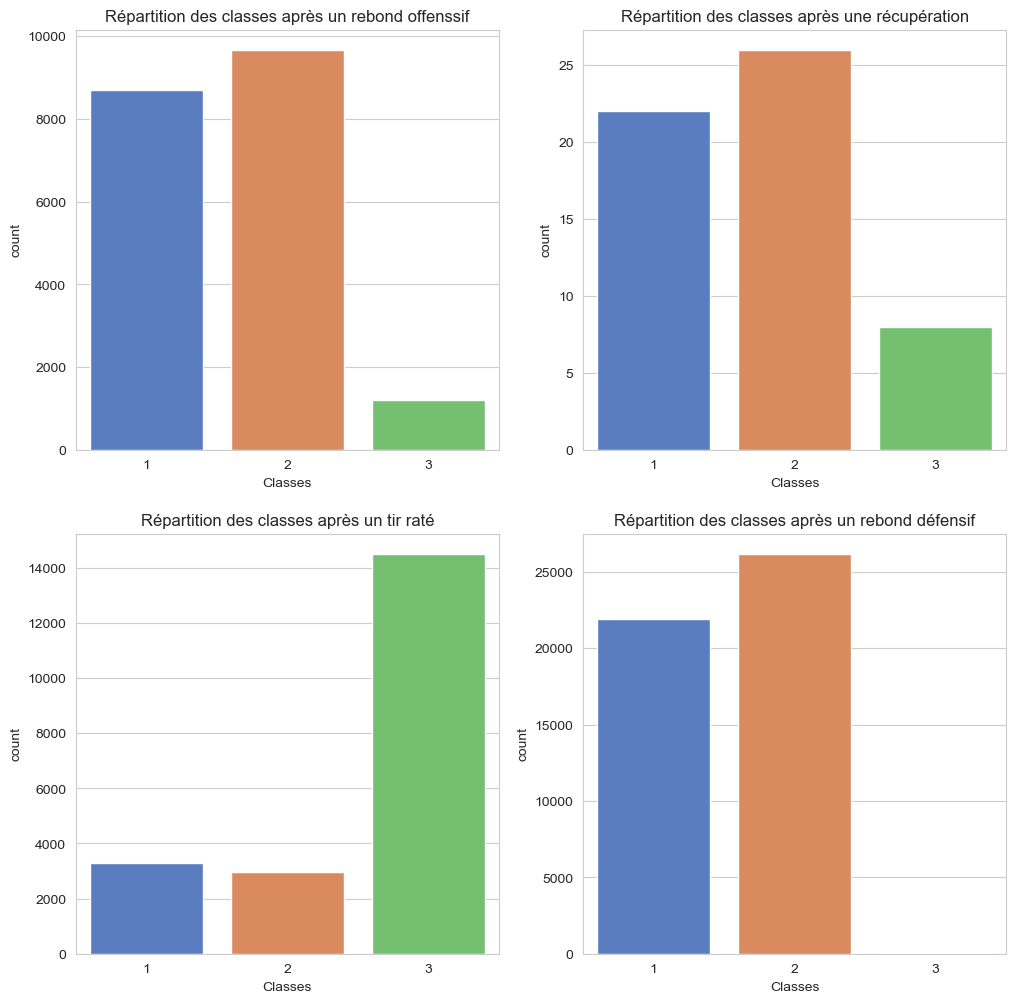

In [82]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

sns.countplot(data = df[df['PREVIOUS_OFF_REBOUND']==True], x='EVENTMSGTYPE', ax=ax1)
ax1.set_title("Répartition des classes après un rebond offenssif")
ax1.set_xlabel("Classes")

sns.countplot(data = df[df['PREVIOUS_OFF_TURNOVER']==True], x='EVENTMSGTYPE', ax=ax2 )
ax2.set_title("Répartition des classes après une récupération")
ax2.set_xlabel("Classes")

sns.countplot(data = df[df['PREVIOUS_OFF_MISSED']==True], x='EVENTMSGTYPE', ax=ax3 )
ax3.set_title("Répartition des classes après un tir raté")
ax3.set_xlabel("Classes")

sns.countplot(data = df[df['PREVIOUS_DEF_REBOUND']==True], x='EVENTMSGTYPE', ax=ax4 )
ax4.set_title("Répartition des classes après un rebond défensif")
ax4.set_xlabel("Classes")

plt.show()

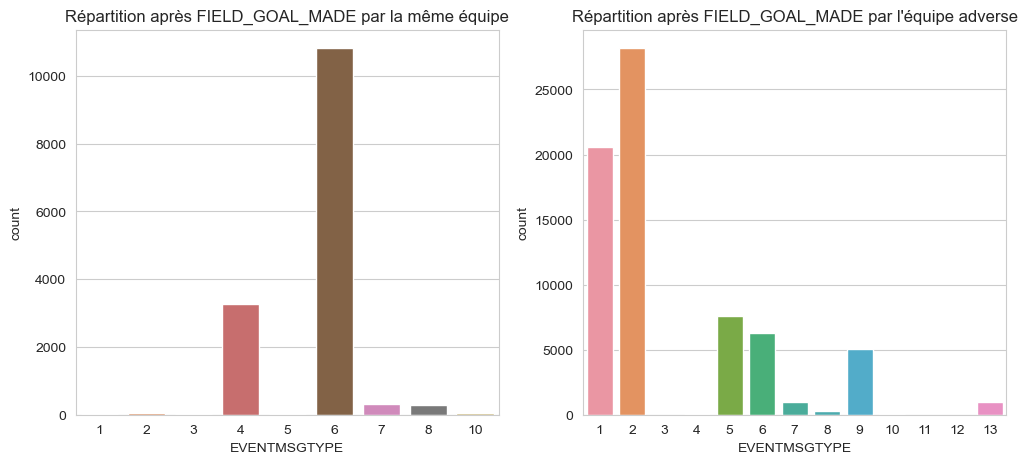

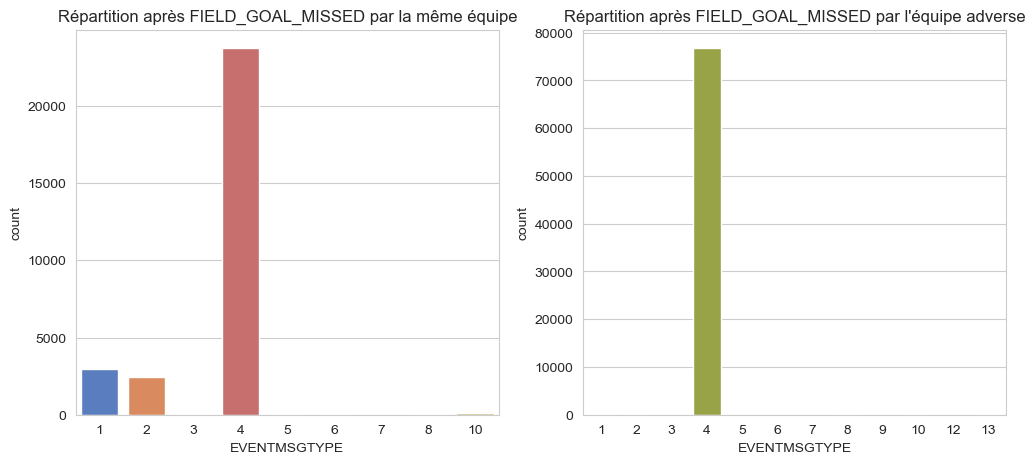

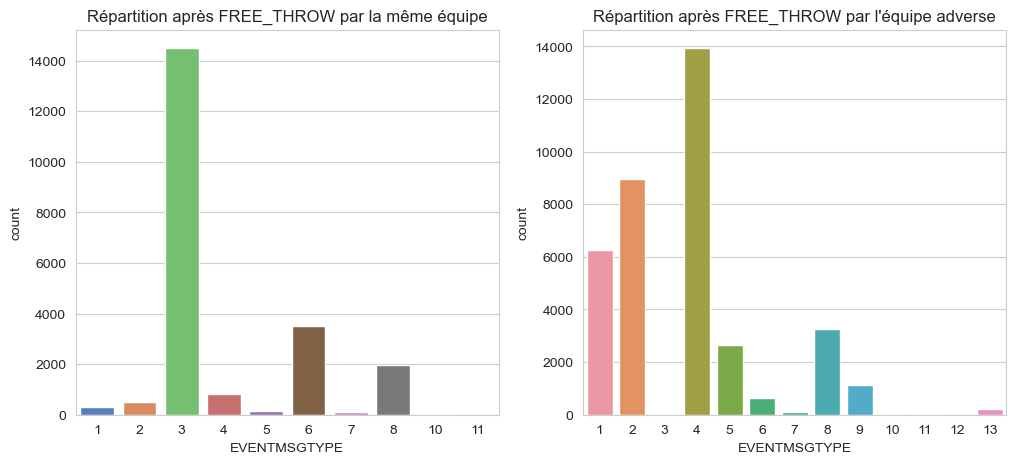

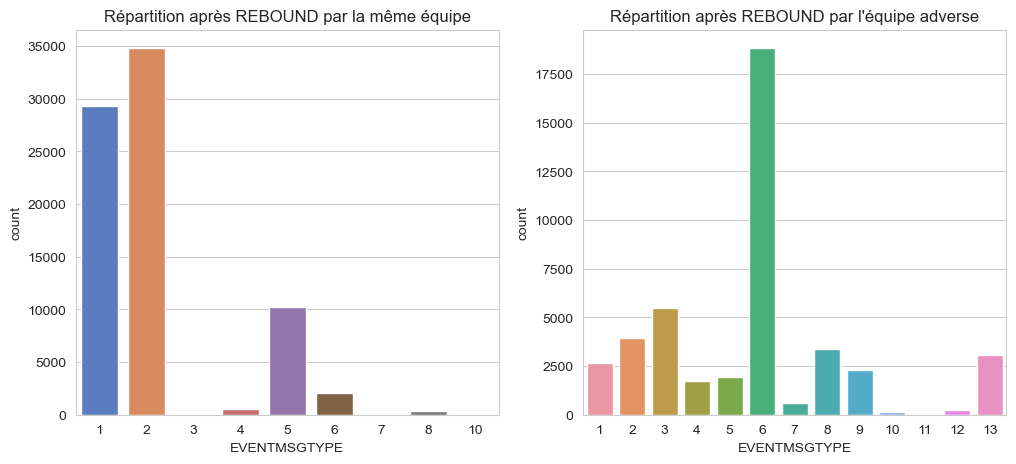

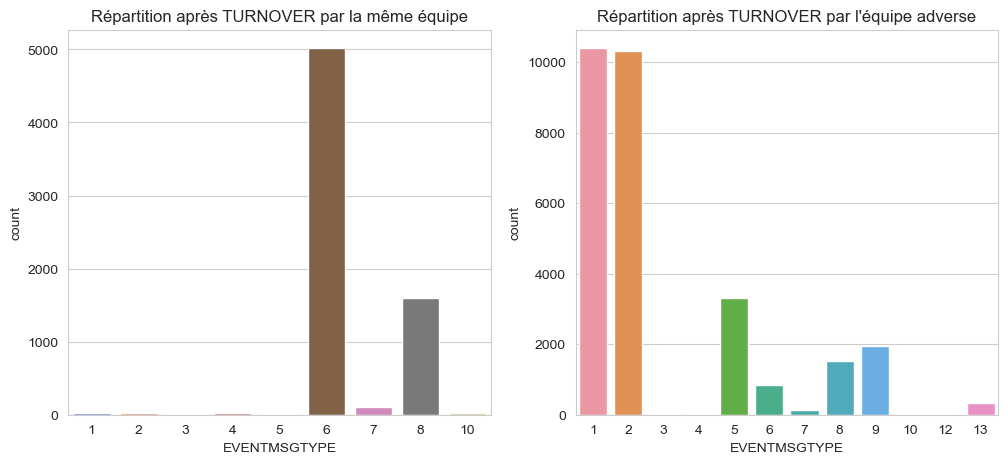

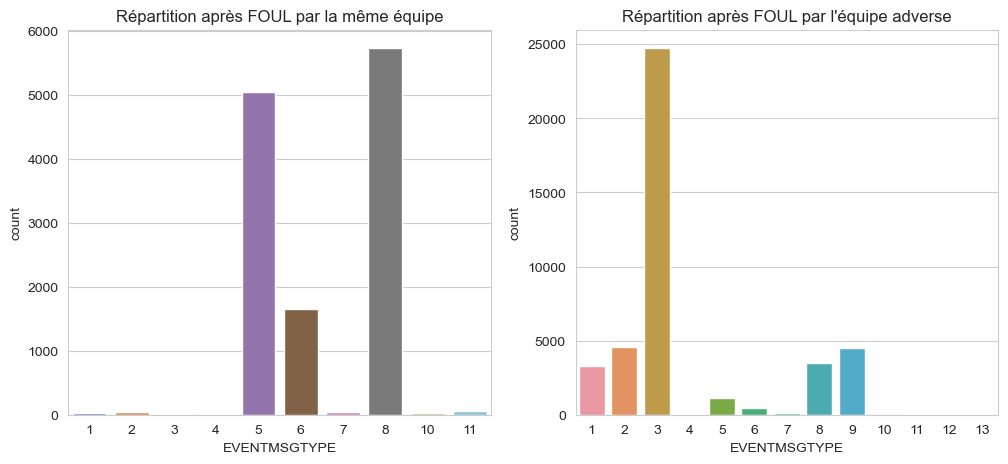

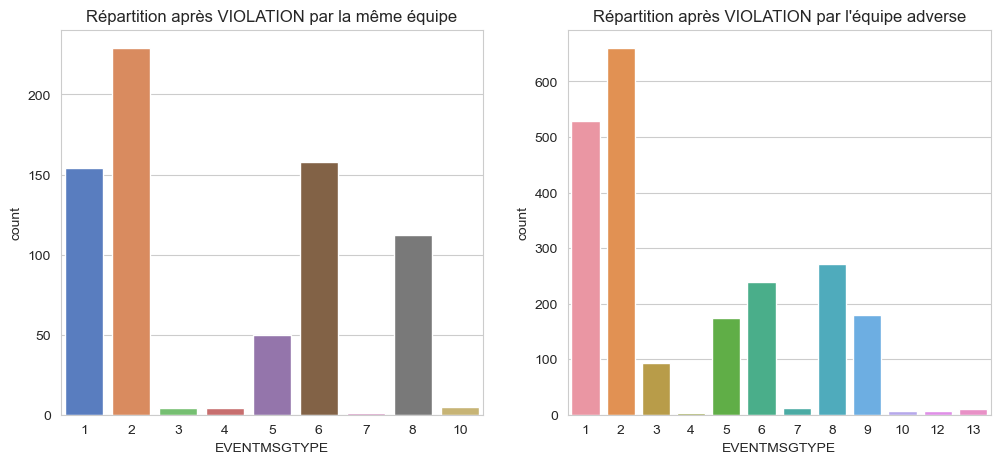

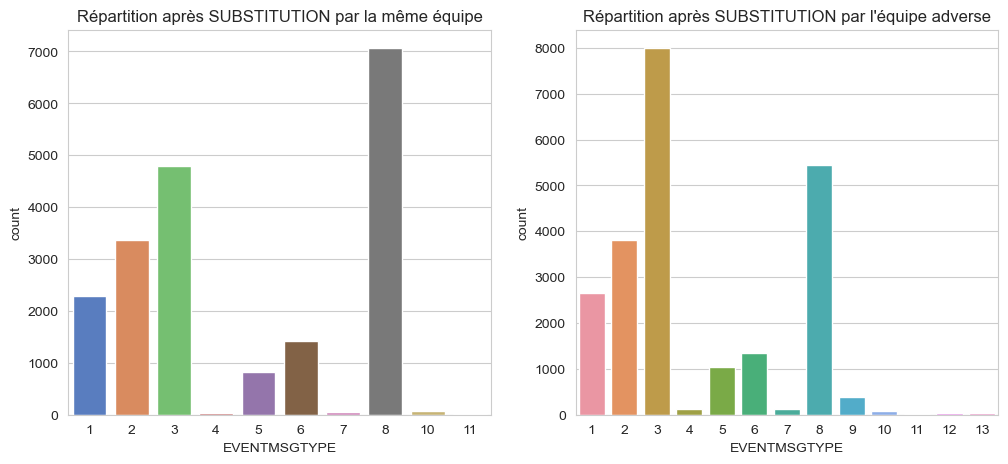

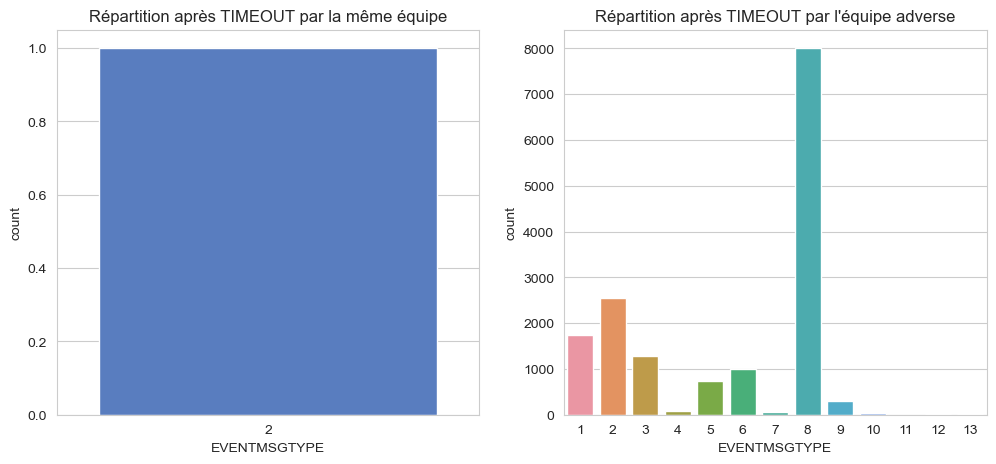

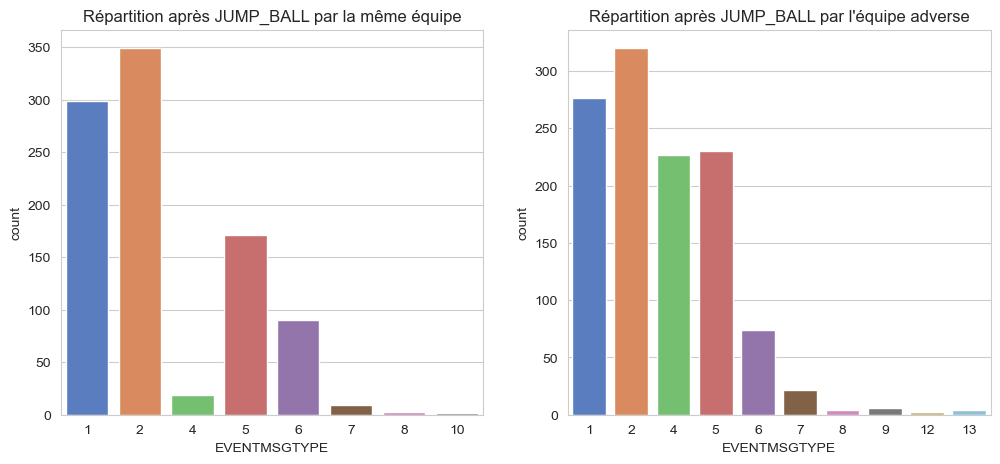

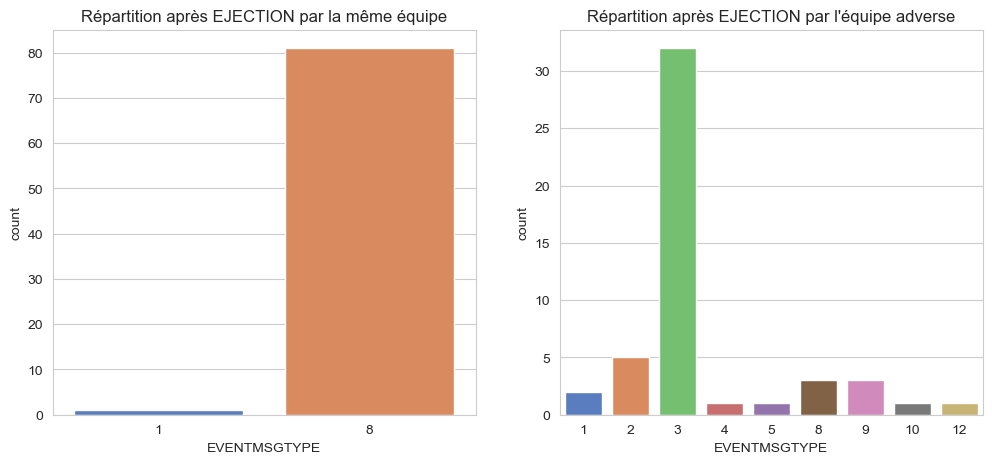

In [89]:
for i in range(1,12):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    sns.countplot(data=df[(df['PREVIOUS_EVENTMSGTYPE']==i) & (df['PLAYER1_TEAM_ID'] == df['PLAYER1_TEAM_ID'].shift(1))], x='EVENTMSGTYPE', ax=ax1)
    ax1.set_title("Répartition après "+ eventmsgtypes[i] + " par la même équipe")

    sns.countplot(data=df[(df['PREVIOUS_EVENTMSGTYPE']==i) & (df['PLAYER1_TEAM_ID'] != df['PLAYER1_TEAM_ID'].shift(1))], x='EVENTMSGTYPE', ax=ax2)
    ax2.set_title("Répartition après "+ eventmsgtypes[i] + " par l'équipe adverse")
    plt.show()
